In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (12, 9)

# Corner Detection

In this notebook we will go over the Harris corner detector to see how corners can be found in images.

Let's first load a sample image. Notice that we scale the data range of the grayscale image to between 0.0 and 1.0.

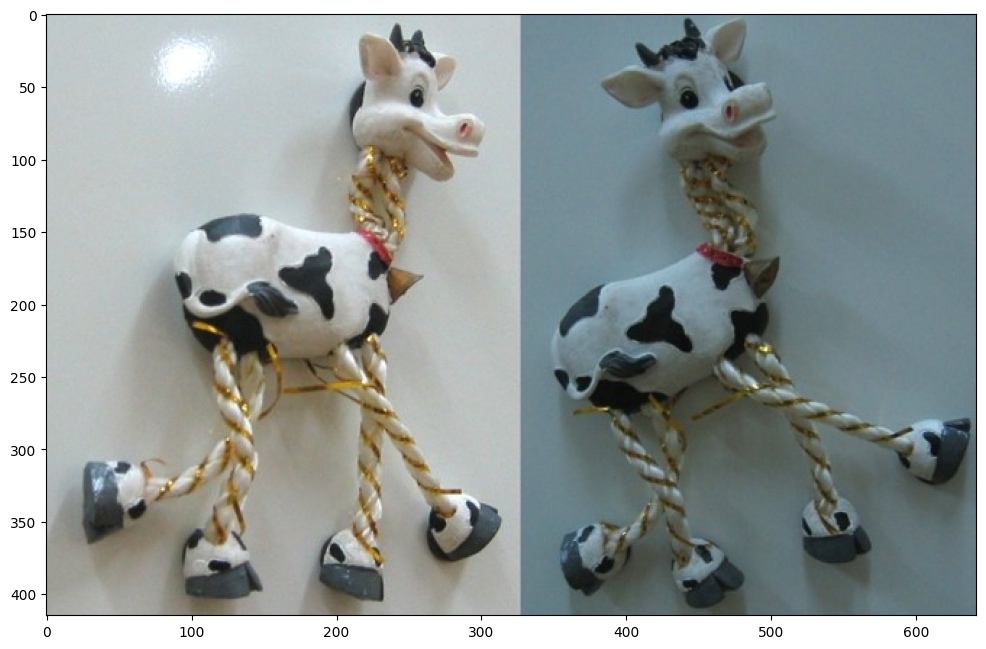

In [2]:
color_img = plt.imread('data/sample.jpg')
img = cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY) / 255.0
height, width = img.shape

plt.imshow(color_img)
plt.show()

In the lecture, we saw that to find corners, a patch containing corners has to have strong derivative response in multiple directions. First, we need to calculate the gradient images in the x and the y directions. [`scipy.ndimage.gaussian_filter()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html) has an `order` parameter that you can set to quickly apply the derivative of Gaussian (DoG) filter to an image.

(2 points) In the cell below, calculate the gradient images $I_x$ and $I_y$ using this funciton, and display the results. Set `sigma=3` when calling `gaussian_filter()`.

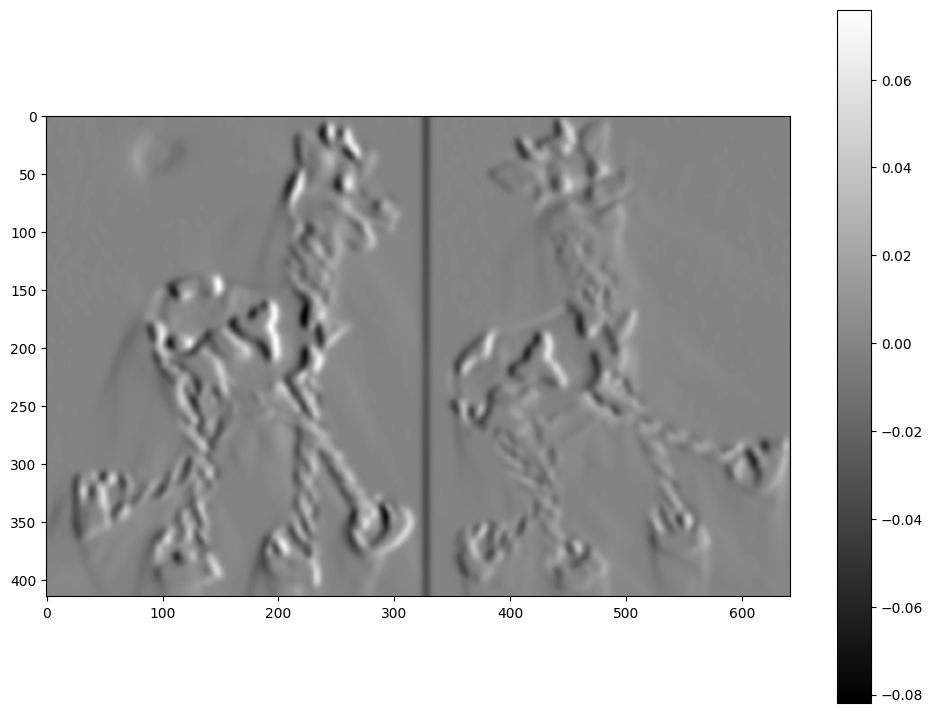

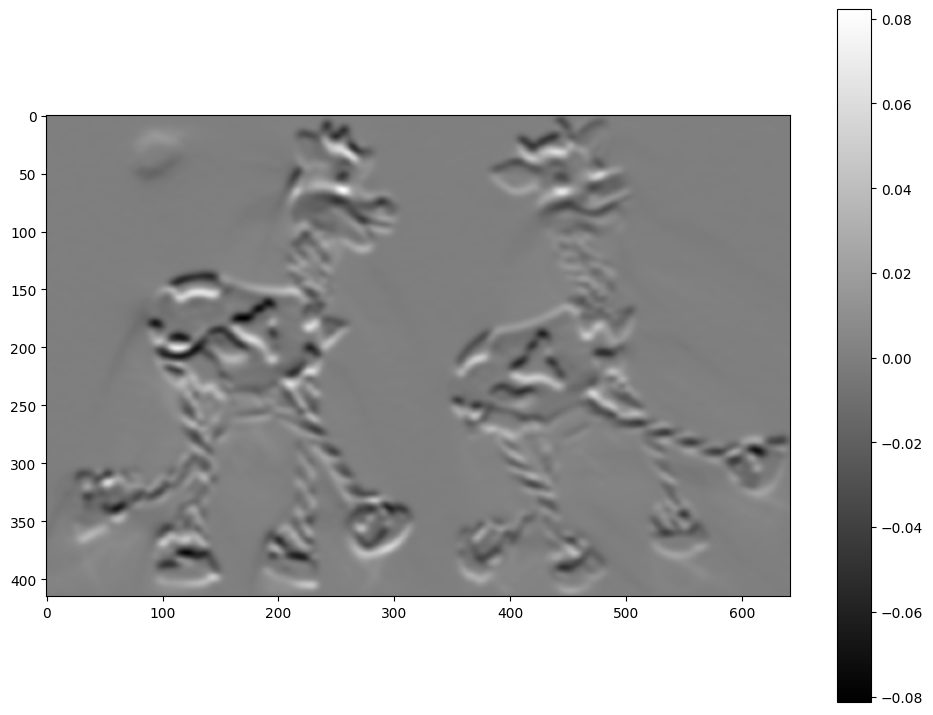

In [3]:
from scipy.ndimage import gaussian_filter

sigma = 3
Ix = gaussian_filter(img, sigma, order=(0,1))
Iy = gaussian_filter(img, sigma, order=(1,0))

plt.imshow(Ix, cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(Iy, cmap='gray')
plt.colorbar()
plt.show()

Given the gradient images, we can construct the $H$ matrix in the slides by calculating $I_x^2$, $I_x I_y$, $I_y I_x$ and $I_y^2$ . Recall from the slides that we are considering a small window for each pixel, therefore, we need to sum up values in these windows. To suppress noise, we will use Gaussian weights for these windows. If you think about it carefully, you'll notice the summation operation is equivalent to Gaussian filtering.

For each pixel we can construct a matrix $H = [[H_{11}, H_{12}], [H_{21}, H_{22}]] = [[\Sigma I_x^2, \Sigma I_x I_y], [\Sigma I_y I_x, \Sigma I_y^2]]$. Also, notice that $H_{12} = H_{21}$. Therefore, for the entire image, we could store the summation results in 3 score maps, corresponding to $H_{11}$, $H_{22}$, $H_{12}$ respectively.

(2 points) Calculate these 3 score maps in the cell below and call them `A`, `B`, and `C`. Set `sigma=3` when calling `gaussian_filter()`.

In [4]:
sigma = 3
A = gaussian_filter(Ix**2, sigma)
B = gaussian_filter(Iy**2, sigma)
C = gaussian_filter(Ix*Iy, sigma)

Given the $I_x^2$, $I_y^2$ and $I_x I_y$ maps (i.e. `A`, `B`, and `C`), we can calculate the "cornerness" response map. You may be tempted to solve for the eigenvalues for each pixel following the slides. However, recall from your linear algebra class that the sum and the product of eigenvalues of a matrix are related to its determinant and trace. Therefore, the response map can be calculated fairly easily by performing very basic arithmetic operations on `A`, `B` and `C`.

(4 points) Do so in the cell below, and visualize the response map. (Set the empirical parameter `k` to 0.04.)

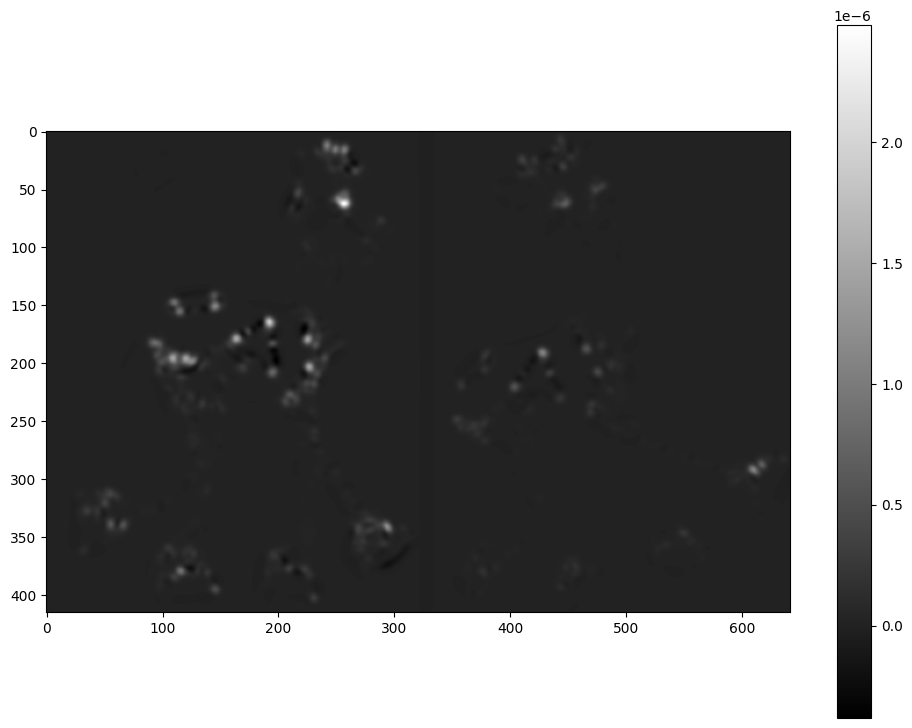

In [5]:
det = A * B - C**2
trace = A + B

k = 0.04
response = det - k * trace**2

plt.imshow(response, cmap='gray')
plt.colorbar()
plt.show()

The following cell normalizes, thresholds, and does non-maximum suppression on the response map and visualizes the detected corners in the input image.

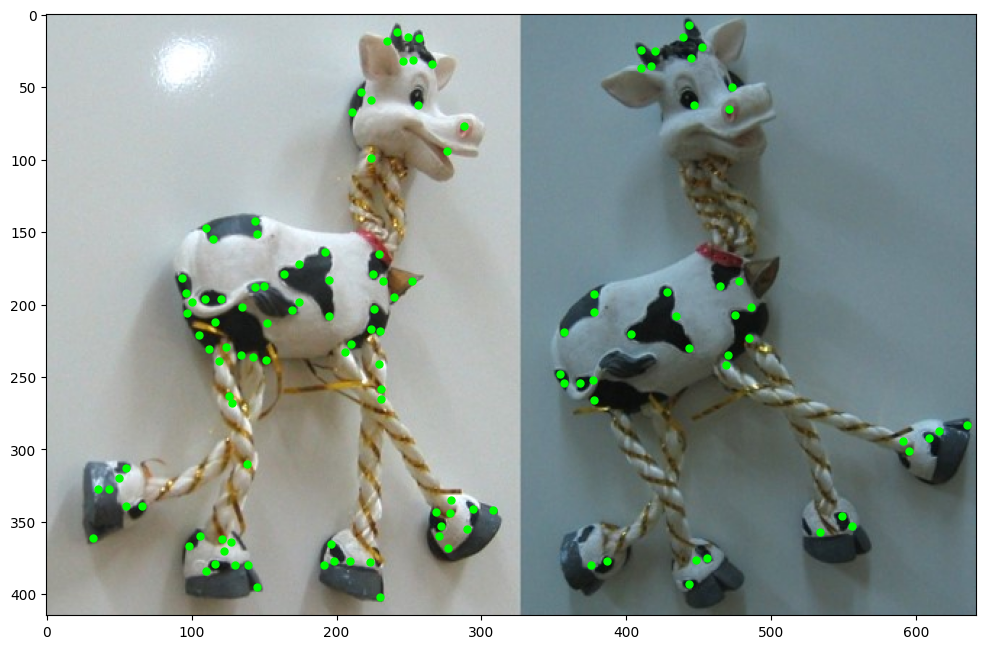

In [6]:
from scipy.ndimage import maximum_filter

def nms(scores, ksize=3):
    suppressed = np.copy(scores)
    filtered = maximum_filter(suppressed, (ksize, ksize))
    maxima = (suppressed == filtered)
    suppressed[np.logical_not(maxima)] = 0
    return suppressed

response = response / np.max(response)
suppressed = nms(response)

threshold = 0.03
ys, xs = np.nonzero(suppressed > threshold)

plt.imshow(color_img)
for y, x in zip(ys, xs):
    plt.plot(x, y, color=(0, 1, 0), marker='o', markersize=5)
plt.show()